# DML GATE Example

This notebook demonstrates how to estimate **Group Average Treatment Effects (GATE)** using Double Machine Learning.
GATE allows us to understand treatment effect heterogeneity by estimating the average effect within specific groups defined by covariates.

### Mathematical Formulation

Let $Y$ be the outcome, $D$ the binary treatment, and $X$ the covariates. We define the Conditional Average Treatment Effect (CATE) as:

$$ \tau(X) = \mathbb{E}[Y(1) - Y(0) \mid X] $$

For a set of groups $G_1, \dots, G_K$ (where $G_k(X)$ is an indicator that unit falls into group $k$), the **GATE** for group $k$ is:

$$ \theta_k = \mathbb{E}[\tau(X) \mid G_k(X)=1] $$

We will:
1. Generate synthetic data with heterogeneous treatment effects.
2. Perform Exploratory Data Analysis (EDA).
3. Estimate GATEs using `gate_esimand` with both automatic quantile groups and custom user-defined groups.

## Generate data

We generate observational data with a nonlinear outcome model, nonlinear treatment assignment, and a heterogeneous (nonlinear) treatment effect $\tau(X)$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from causalis.data import CausalDatasetGenerator, CausalData

# Reproducibility
np.random.seed(42)

# 1) confounders and their distributions
confounder_specs = [
    {"name": "tenure_months",     "dist": "normal",   "mu": 24, "sd": 12},
    {"name": "avg_sessions_week", "dist": "normal",   "mu": 5,  "sd": 2},
    {"name": "spend_last_month",  "dist": "uniform",  "a": 0,   "b": 200},
    {"name": "premium_user",      "dist": "bernoulli","p": 0.25},
    {"name": "urban_resident",    "dist": "bernoulli","p": 0.60},
]

# Indices
TENURE, SESS, SPEND, PREMIUM, URBAN = range(5)

# 2) Nonlinear baseline for outcome f_y(X) = X @ beta_y + g_y(X)
beta_y = np.array([0.03, 0.20, 0.01, 1.20, 0.60], dtype=float)

def g_y(X: np.ndarray) -> np.ndarray:
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]
    return (
        1.2 * np.sin(2.0 * np.pi * tenure_years)
        + 0.02 * (sessions - 5.0) ** 2
        + 0.0015 * (spend - 100.0) * (sessions - 5.0)
        + 0.4 * premium * (sessions - 5.0)
        + 0.3 * urban * np.tanh((spend - 100.0) / 50.0)
    )

# 3) Nonlinear treatment score f_t(X) = X @ beta_t + g_t(X)
beta_d = np.array([0.010, 0.12, 0.001, 0.80, 0.25], dtype=float)

def g_d(X: np.ndarray) -> np.ndarray:
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]
    soft_spend = 1.2 * np.tanh((spend - 80.0) / 40.0)
    return (
        0.6 * soft_spend
        + 0.15 * (sessions - 5.0) * (tenure_years - 2.0)
        + 0.25 * premium * (urban - 0.5)
    )

# 4) Heterogeneous, nonlinear treatment effect tau(X)
def tau_fn(X: np.ndarray) -> np.ndarray:
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]
    tau = (
        1.0
        + 0.8 * (1.0 / (1.0 + np.exp(-(sessions - 5.0))))
        + 0.5 * premium
        - 0.6 * np.clip(tenure_years / 5.0, 0.0, 1.0)
        + 0.2 * urban * (spend - 100.0) / 100.0
    )
    return np.clip(tau, 0.2, 2.5)

# 5) Noise and prevalence
sigma_y = 3.5
target_d_rate = 0.35

# 6) Build generator
gen = CausalDatasetGenerator(
    outcome_type="continuous",
    sigma_y=sigma_y,
    target_d_rate=target_d_rate,
    seed=42,
    confounder_specs=confounder_specs,
    beta_y=beta_y,
    beta_d=beta_d,
    g_y=g_y,
    g_d=g_d,
    tau=tau_fn,
)

# 7) Generate data
n = 10000
generated_df = gen.generate(n)

# Ground-truth ATT
true_att = float(generated_df.loc[generated_df["d"] == 1, "cate"].mean())
print(f"Ground-truth ATT from the DGP: {true_att:.3f}")

# 8) Wrap as CausalData
causal_data = CausalData(
    df=generated_df,
    treatment="d",
    outcome="y",
    confounders=[
        "tenure_months",
        "avg_sessions_week",
        "spend_last_month",
        "premium_user",
        "urban_resident",
    ],
)

causal_data.df.head()

Ground-truth ATT from the DGP: 1.386


,y,d,tenure_months,avg_sessions_week,spend_last_month,premium_user,urban_resident
0,2.237316,0.0,27.656605,5.352554,72.552568,1.0,0.0
1,5.771469,0.0,11.520191,6.798247,188.481287,1.0,0.0
2,6.374653,1.0,33.005414,2.055459,51.040440,0.0,1.0
3,2.364177,1.0,35.286777,4.429404,166.992239,0.0,1.0
4,8.378079,0.0,0.587578,6.658307,179.371126,0.0,0.0


## EDA

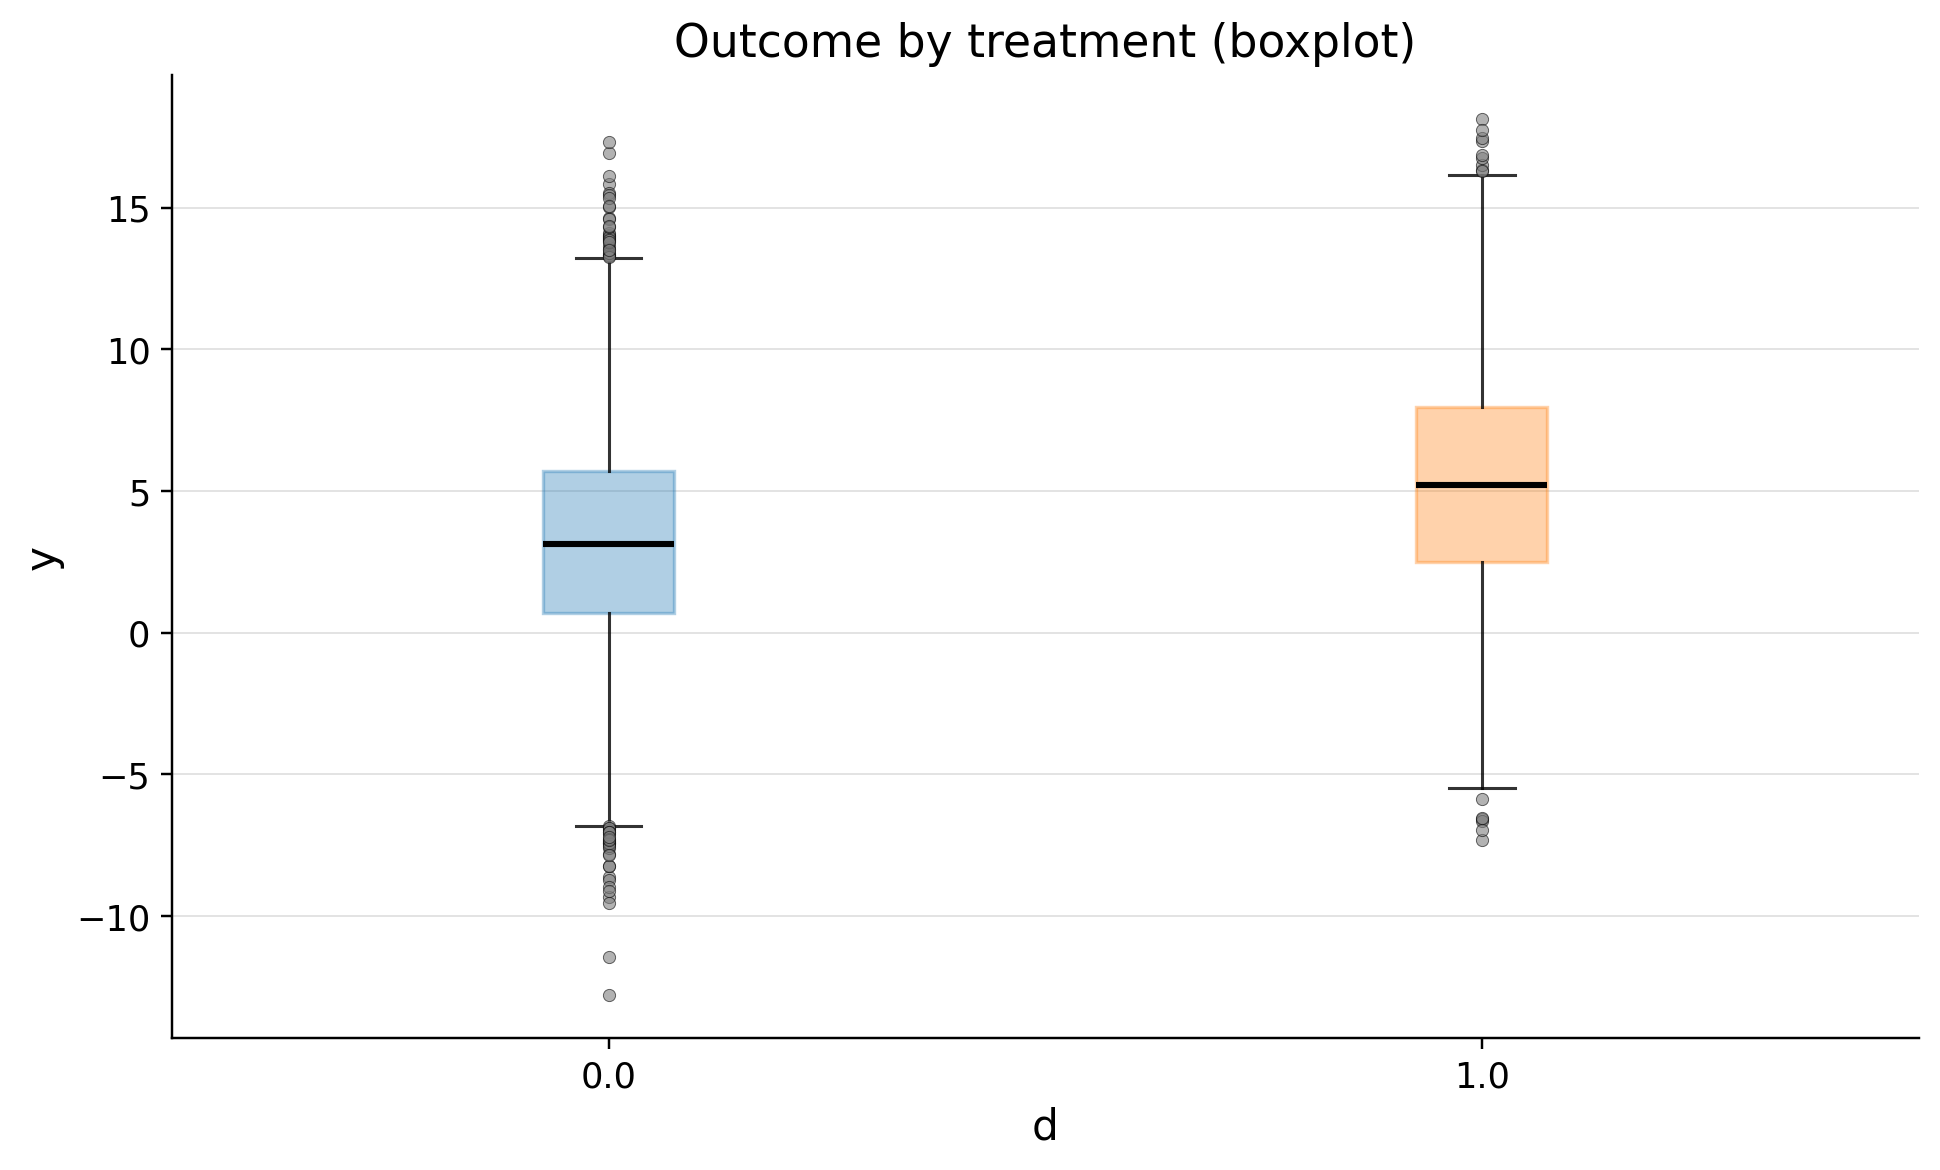

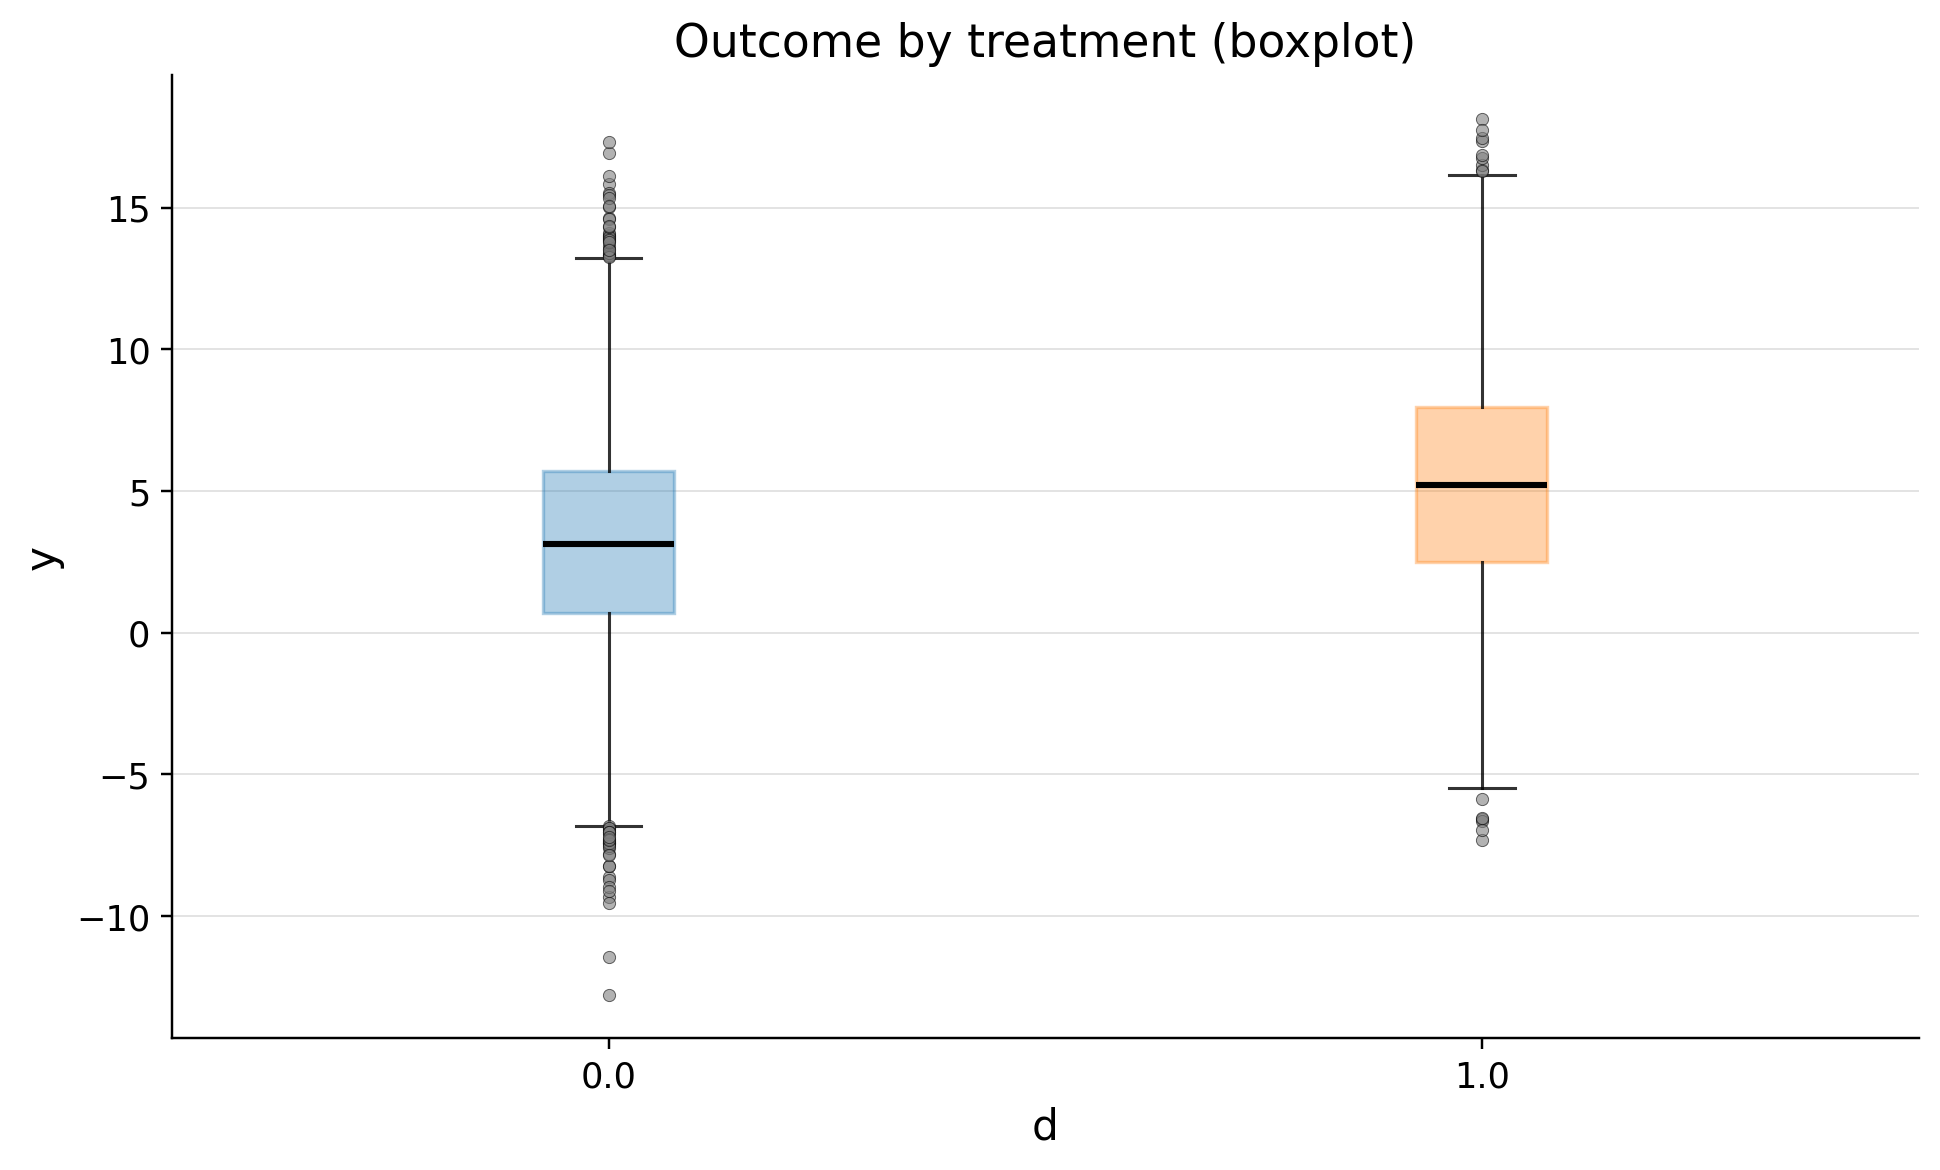

In [2]:
from causalis.eda import CausalEDA
eda = CausalEDA(causal_data)
eda.outcome_stats()
eda.outcome_hist()
eda.outcome_boxplot()


## Inference: Estimating GATE

We use `gate_esimand` to estimate Group Average Treatment Effects.
This function works by leveraging the **orthogonal signal** from the DoubleML framework.

### Methodology

1. **Orthogonal Signal**: We fit a DoubleML IRM model to obtain a score $\psi(W;\hat{\eta})$ such that:

   $$ \mathbb{E}[\psi(W; \hat{\eta}) \mid X] \approx \tau(X) $$

   where $W = (Y, D, X)$ and $\hat{\eta}$ are the estimated nuisance parameters.

2. **Best Linear Predictor (BLP)**: We assume a linear model for the CATE using group indicators $G(X)$:

   $$ \tau(X) \approx \sum_k \theta_k G_k(X) $$

   We estimate coefficients $\theta$ by solving the BLP optimization:

   $$ \hat{\theta} = \arg\min_{\theta} \sum_{i=1}^N (\psi(W_i) - \theta^\top G(X_i))^2$$

When $G(X)$ consists of mutually exclusive group indicators, $\hat{\theta}_k$ corresponds to the average of the orthogonal signal within group $k$, providing a consistent estimate of the GATE.

In [3]:
from causalis.inference.gate.gate_esimand import gate_esimand

### 1. GATE by CATE Quantiles
If no groups are provided, `gate_esimand` automatically creates groups based on quantiles of the estimated CATE (Conditional Average Treatment Effect).

In [4]:
# Estimate GATE with 5 quantile groups
gate_quantiles = gate_esimand(causal_data, n_groups=5, confidence_level=0.95)

print("GATE Results (Quantiles):")
display(gate_quantiles)

GATE Results (Quantiles):


,group,n,theta,std_error,p_value,ci_lower,ci_upper
0,Group_0,2000,1.376851,0.212620,9.441200e-11,0.960123,1.793579
1,Group_1,2000,0.899152,0.196052,4.512072e-06,0.514896,1.283408
2,Group_2,2000,1.114911,0.194088,9.226342e-09,0.734507,1.495316
3,Group_3,2000,1.190621,0.188706,2.801072e-10,0.820765,1.560478
4,Group_4,2000,1.332698,0.207103,1.235086e-10,0.926784,1.738612


### 2. GATE by User-Defined Groups
We can also define custom groups based on covariates. For example, let's group users by their tenure:
- **< 1 year**
- **1-3 years**
- **> 3 years**

In [5]:
# Define custom groups
tenure = causal_data.df['tenure_months']
groups = pd.cut(tenure, bins=[-np.inf, 12, 36, np.inf], labels=['<1y', '1-3y', '>3y'])

# Estimate GATE
gate_custom = gate_esimand(causal_data, groups=groups, confidence_level=0.95)

print("GATE Results (Tenure Groups):")
display(gate_custom)

GATE Results (Tenure Groups):


,group,n,theta,std_error,p_value,ci_lower,ci_upper
0,tenure_months_1-3y,6785,1.187370,0.107453,2.189553e-28,0.976765,1.397974
1,tenure_months_<1y,1649,1.231591,0.221586,2.727795e-08,0.797290,1.665891
2,tenure_months_>3y,1566,1.104541,0.221472,6.123645e-07,0.670464,1.538617


In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))

# Calculate error bars (distance from the mean)
yerr = [
    gate_custom['theta'] - gate_custom['ci_lower'],
    gate_custom['ci_upper'] - gate_custom['theta']
]

plt.errorbar(
    x=gate_custom['group'].astype(str),
    y=gate_custom['theta'],
    yerr=yerr,
    fmt='o',
    capsize=5,
    label='GATE Estimate'
)

plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Group')
plt.ylabel('GATE')
plt.title('Group Average Treatment Effects (Custom Groups)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()